<a href="https://colab.research.google.com/github/magland/spikeforest_batch_run/blob/master/notebooks/spikeforest_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SpikeForest bionet analysis

This notebook represents a complete spikeforest analysis of the bionet studies. You should execute the first few cells and then skip down to the section of interest below.

In [0]:
# Only run this cell if you are running this on a hosted runtime that does not have these packages installed
# %%capture is used to suppress the output... this should take up to a minute to complete
%%capture
!pip install spikeforest
!pip install git+https://github.com/magland/spikeforest_batch_run

In [1]:
# Import the python packages -- autoreload is used for development purposes
%load_ext autoreload
%autoreload 2

import spikeforest as sf
from kbucket import client as kb

vdomr: using colab


In [0]:
## Configure readonly access to kbucket -- use this if you only want to browse the results ---
sf.kbucketConfigRemote(name='spikeforest1-readonly')

In [3]:
## Configure read/write access to kbucket -- use this if you are preparing the studies or the processing batches
sf.kbucketConfigRemote(name='spikeforest1-readwrite',ask_password=True)

Enter password: ··········
Pairio user set to spikeforest. Test succeeded.


## Prepare recordings

In [0]:
def read_text_file(path):
  path2=kb.realizeFile(path)
  if path2 is None:
    raise Exception('Unable to realize file: '+path)
  with open(path2,'r') as f:
    return f.read()
  
def prepare_bionet_studies(*,basedir,channels):
  study_set_name='bionet'
  studies=[]
  recordings=[]
  names=['bionet_drift','bionet_shuffle','bionet_static']
  for name in names:
    study_name=name
    study_dir=basedir+'/bionet/'+name
    description=read_text_file(study_dir+'/readme.txt')
    study0=dict(
        name=study_name,
        study_set=study_set_name,
        directory=study_dir,
        description=description
    )
    studies.append(study0)
    dd=kb.readDir(study_dir)
    for dsname in dd['dirs']:
        dsdir='{}/{}'.format(study_dir,dsname)
        rec0=dict(
            name=dsname,
            study=study_name,
            description='',
            directory=dsdir,
            channels=channels
        )
        if len(rec0['channels'])>0:
          units=sf.sf_batch.select_units_on_channels(
              recording_dir=dsdir,
              firings=dsdir+'/firings_true.mda',
              channels=rec0['channels']
          )
          rec0['units_true']=units
        recordings.append(rec0)
  return studies, recordings

def prepare_magland_synth_studies(*,basedir):
  study_set_name='magland_synth'
  studies=[]
  recordings=[]
  names=[]
  names=names+['datasets_noise10_K10_C4','datasets_noise10_K10_C8']
  names=names+['datasets_noise10_K20_C4','datasets_noise10_K20_C8']
  names=names+['datasets_noise20_K10_C4','datasets_noise20_K10_C8']
  names=names+['datasets_noise20_K20_C4','datasets_noise20_K20_C8']
  description=read_text_file(basedir+'/magland_synth/readme.txt')
  for name in names:
    study_name='magland_synth_'+name[9:]
    study_dir=basedir+'/magland_synth/'+name
    study0=dict(
        name=study_name,
        study_set=study_set_name,
        directory=study_dir,
        description=description
    )
    studies.append(study0)
    dd=kb.readDir(study_dir)
    for dsname in dd['dirs']:
        dsdir='{}/{}'.format(study_dir,dsname)
        recordings.append(dict(
            name=dsname,
            study=study_name,
            directory=dsdir,
            description='One of the recordings in the {} study'.format(study_name)
        ))
  return studies, recordings

In [0]:
basedir='kbucket://15734439d8cf/groundtruth'

In [21]:
channels=[0,1,2,3,4,5,6,7]
studies,recordings=prepare_bionet_studies(basedir=basedir,channels=channels)
kb.saveObject(dict(studies=studies,recordings=recordings),key=dict(name='spikeforest_bionet_recordings'))

::::::::::::::::::::::::::::: ComputeUnitsInfo
Found output "json_out" in cache collection: spikeforest
Using outputs from cache: spikeforest
::::::::::::::::::::::::::::: ComputeUnitsInfo
Found output "json_out" in cache collection: spikeforest
Using outputs from cache: spikeforest
::::::::::::::::::::::::::::: ComputeUnitsInfo
Found output "json_out" in cache collection: spikeforest
Using outputs from cache: spikeforest
::::::::::::::::::::::::::::: ComputeUnitsInfo
Found output "json_out" in cache collection: spikeforest
Using outputs from cache: spikeforest
::::::::::::::::::::::::::::: ComputeUnitsInfo
Found output "json_out" in cache collection: spikeforest
Using outputs from cache: spikeforest
::::::::::::::::::::::::::::: ComputeUnitsInfo
Found output "json_out" in cache collection: spikeforest
Using outputs from cache: spikeforest
::::::::::::::::::::::::::::: ComputeUnitsInfo
Found output "json_out" in cache collection: spikeforest
Using outputs from cache: spikeforest
::::::

In [26]:
studies,recordings=prepare_magland_synth_studies(basedir=basedir)
kb.saveObject(dict(studies=studies,recordings=recordings),key=dict(name='spikeforest_magland_synth_recordings'))

Already on server.


## Create summarize recordings batches

In [0]:
def create_summarize_recordings_batch(*,recordings_name,batch_name):
  print('Creating summarize_recordings batch: '+batch_name)
  SF=sf.SFData()
  SF.loadRecordings(key=dict(name=recordings_name))
  
  jobs=[]
  for name in SF.studyNames():
    study=SF.study(name)
    for recname in study.recordingNames():
      R=study.recording(recname)
      job=dict(
          command='summarize_recording',
          label=R.name(),
          recording=R.getObject()
      )
      jobs.append(job)
  batch=dict(jobs=jobs)
  print('Number of jobs: {}'.format(len(jobs)))
  kb.saveObject(key=dict(batch_name=batch_name),object=batch)

In [28]:
create_summarize_recordings_batch(recordings_name='spikeforest_bionet_recordings',batch_name='summarize_recordings_bionet')
create_summarize_recordings_batch(recordings_name='spikeforest_magland_synth_recordings',batch_name='summarize_recordings_magland_synth')

Creating summarize_recordings batch: summarize_recordings_bionet
Number of jobs: 36
Already on server.
Creating summarize_recordings batch: summarize_recordings_magland_synth
Number of jobs: 80
Already on server.


To run these batches, go to a computer with resources somewhere and run something like:

```
bin/sf_run_batch [name_of_batch] --run_prefix "srun -c 2 -n 40"
```

where bin/sf_run_batch is found in the spikeforest_batch_run repository.

Alternatively, you can test run it in this notebook using the following commands:

In [29]:
## Note: usually you would not run this cell -- see the note above.

import spikeforest_batch_run as sbr
# Execute prepareBatch once (serially)
sbr.prepareBatch(batch_name='summarize_recordings_bionet')

# Execute runBatch many times in parallel
sbr.runBatch(batch_name='summarize_recordings_bionet')

# Execute assembleBatchResults once (serially)
sbr.assembleBatchResults(batch_name='summarize_recordings_bionet')

Preparing batch summarize_recordings_bionet with 36 jobs
Running batch summarize_recordings_bionet with 36 jobs
Assembling results for batch summarize_recordings_bionet with 36 jobs
ASSEMBLING: drift_8x_A_2A
ASSEMBLING: drift_8x_A_2B
ASSEMBLING: drift_8x_A_4A
ASSEMBLING: drift_8x_A_4B
ASSEMBLING: drift_8x_B_2A
ASSEMBLING: drift_8x_B_2B
ASSEMBLING: drift_8x_B_4A
ASSEMBLING: drift_8x_B_4B
ASSEMBLING: drift_8x_C_2A
ASSEMBLING: drift_8x_C_2B
ASSEMBLING: drift_8x_C_4A
ASSEMBLING: drift_8x_C_4B
ASSEMBLING: shuffle_8x_A_2A
ASSEMBLING: shuffle_8x_A_2B
ASSEMBLING: shuffle_8x_A_4A
ASSEMBLING: shuffle_8x_A_4B
ASSEMBLING: shuffle_8x_B_2A
ASSEMBLING: shuffle_8x_B_2B
ASSEMBLING: shuffle_8x_B_4A
ASSEMBLING: shuffle_8x_B_4B
ASSEMBLING: shuffle_8x_C_2A
ASSEMBLING: shuffle_8x_C_2B
ASSEMBLING: shuffle_8x_C_4A
ASSEMBLING: shuffle_8x_C_4B
ASSEMBLING: static_8x_A_2A
ASSEMBLING: static_8x_A_2B
ASSEMBLING: static_8x_A_4A
ASSEMBLING: static_8x_A_4B
ASSEMBLING: static_8x_B_2A
ASSEMBLING: static_8x_B_2B
ASSEMBLI

## Browse recordings

In [4]:
SF=sf.SFData()
SF.loadRecordings(key=dict(name='spikeforest_bionet_recordings'))
SF.loadRecordings(key=dict(name='spikeforest_magland_synth_recordings'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_bionet',name='job_results'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_magland_synth',name='job_results'))

Loaded 0 sorting results and 36 recording summary results
Loaded 0 sorting results and 80 recording summary results


In [11]:
X=sf.SFSelectWidget(sfdata=SF,mode='recording')
display(X)

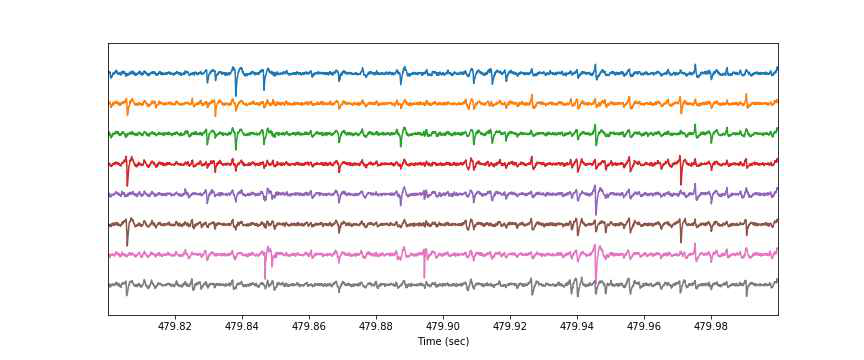

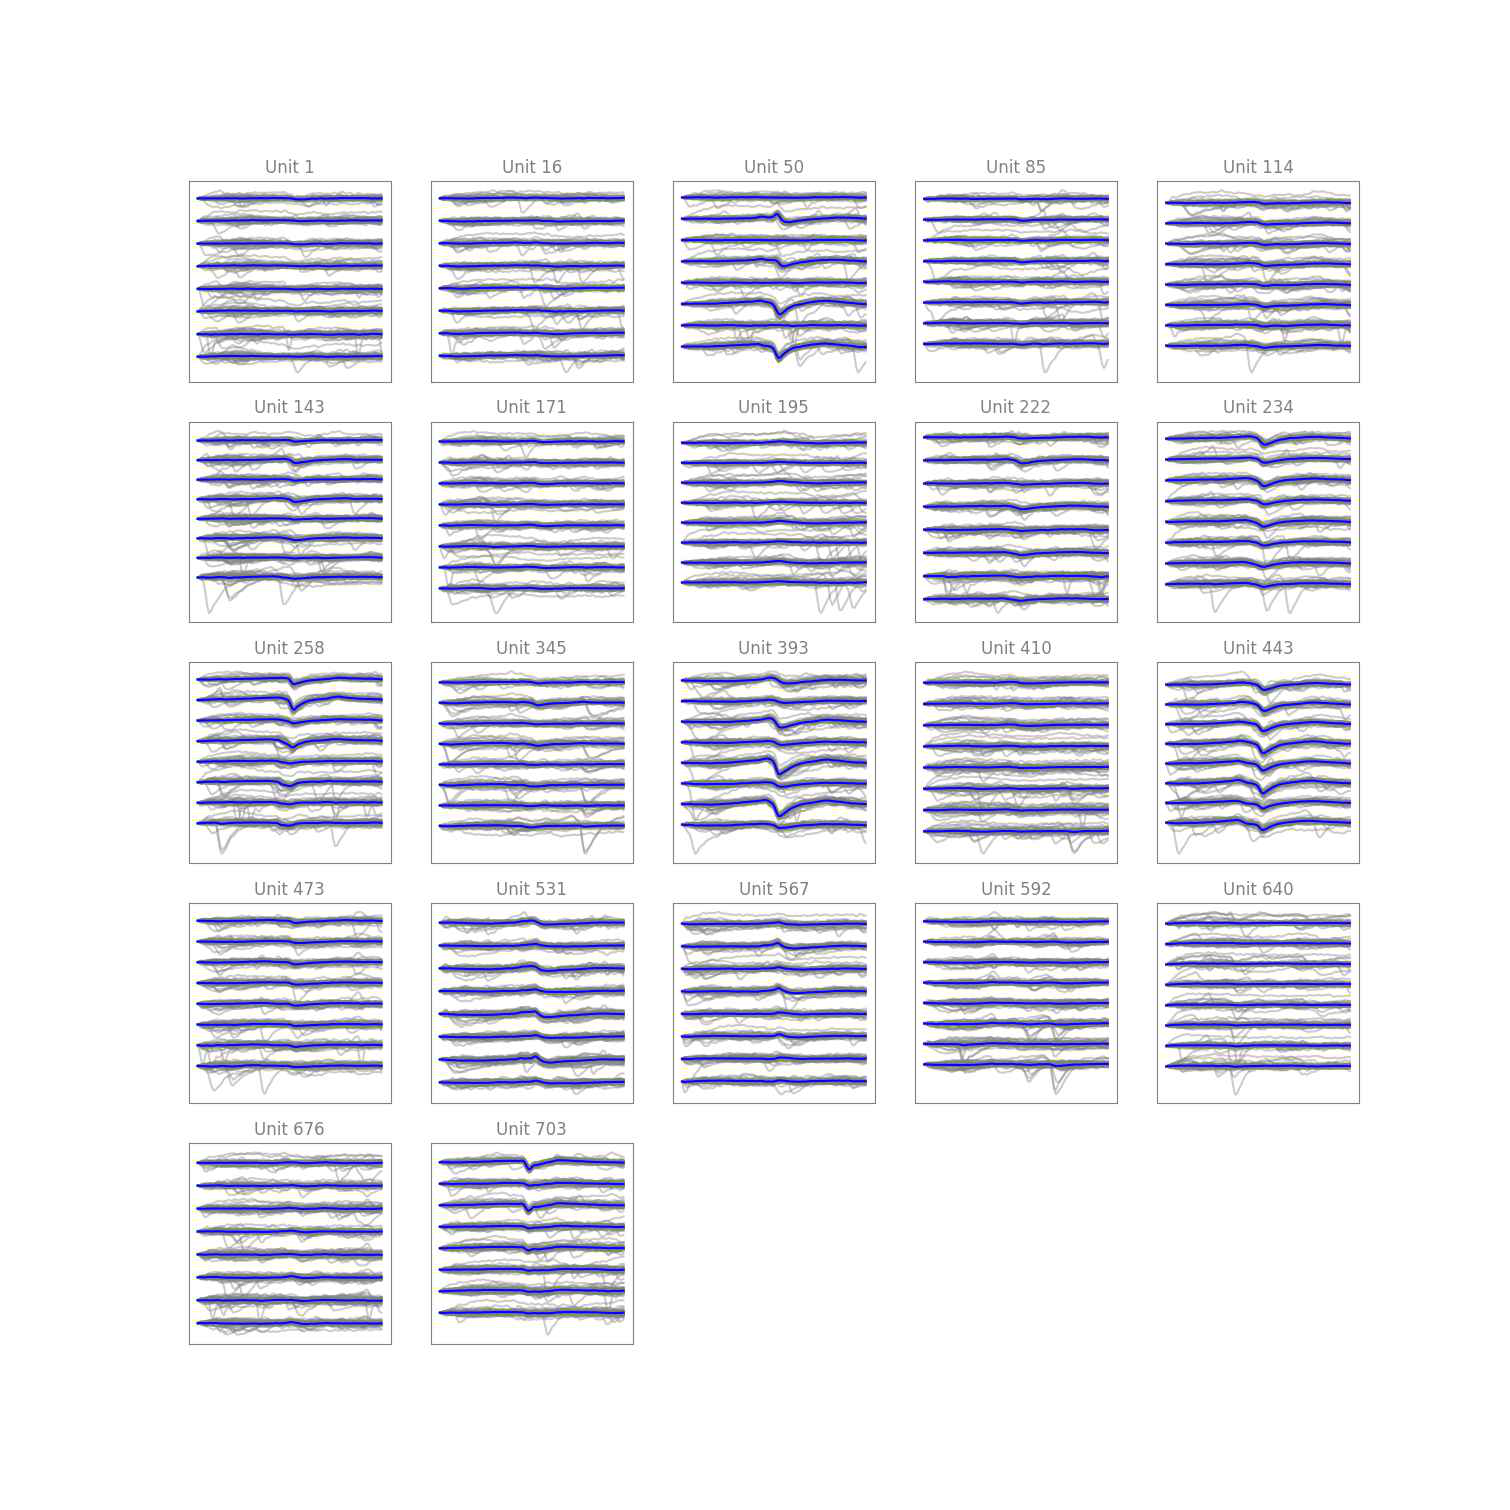

firing_rate  num_events  peak_channel        snr  unit_id
0      2.387500        2292             0   3.343870        1
1      2.116667        2032             7   3.443811        3
2      2.066667        1984             5  52.485138        4
3      2.362500        2268             2  27.300165        6
4      2.500000        2400             5   2.593275       16
5      2.066667        1984             2   4.721575       21
6      1.562500        1500             3  14.430388       26
7      2.700000        2592             2   2.585488       28
8      2.425000        2328             7  36.712619       50
9      2.091667        2008             0   3.441622       76
10     1.595833        1532             1   2.688525       83
11     2.562500        2460             5   2.651218       84
12     1.125000        1080             7   4.311581       85
13     1.866667        1792             2   8.701670      101
14     1.591667        1528             0  39.065159      104
15     1.200000        1152             4  12.539603      105
16     1.841667        1768             5   5.921046      114
17     1.187500        1140             7   7.030059      120
18     1.091667        1048             7   5.039221      125
19     1.933333        1856             5   9.906497      135
20     1.658333        1592             3  10.537055      143
21     1.191667        1144             7   5.959964      148
22     0.691667         664             7   7.627100      163
23     5.708333        5480             1   3.508632      170
24     5.779167        5548             4   4.660825      171
25     5.750000        5520             0  13.201525      176
26     5.820833        5588             1  24.188160      186
27     5.566667        5344             6  11.198612      188
28     5.637500        5412             6   3.891501      195
29     5.800000        5568             1   3.700030      204
..          ...         ...           ...        ...      ...
55     2.541667        2440             0   3.004774      438
56     3.516667        3376             5  29.866201      443
57     2.691667        2584             4   7.942449      455
58     3.425000        3288             4  21.820000      456
59     3.120833        2996             1   4.837954      457
60     2.837500        2724             2   7.311971      473
61     2.937500        2820             7  10.332367      487
62     3.279167        3148             2  24.499233      490
63     2.966667        2848             7  11.504325      504
64     3.425000        3288             6  12.532581      531
65     3.745833        3596             0  26.008839      550
66     3.425000        3288             0   6.367813      552
67     3.504167        3364             5   7.273900      563
68     3.062500        2940             3   9.780318      567
69     3.554167        3412             2  23.047107      570
70     3.704167        3556             3   8.562215      572
71     2.966667        2848             5   5.863559      585
72     0.233333         224             7  10.521990      592
73     0.941667         904             4   5.502740      595
74     7.145833        6860             4   2.007878      615
75     8.212500        7884             2   3.966408      635
76     0.654167         628             7   4.795482      640
77     1.083333        1040             0  23.298317      641
78    10.200000        9792             5   2.685333      668
79     5.791667        5560             7   2.819656      673
80     8.854167        8500             7   3.012301      676
81     5.379167        5164             4   5.808187      688
82     3.720833        3572             2   5.086393      697
83     4.979167        4780             5   8.696459      701
84     6.700000        6432             2  19.740775      703

[85 rows x 5 columns]

In [12]:
R=X.recording()
display(R.plot('timeseries'))
display(R.plot('waveforms_true'))
display(R.trueUnitsInfo())

In [13]:
R.plotNames()

['timeseries', 'waveforms_true']

## Create spike sorting batches

In [14]:
SF=sf.SFData()
SF.loadRecordings(key=dict(name='spikeforest_bionet_recordings'))
SF.loadRecordings(key=dict(name='spikeforest_magland_synth_recordings'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_bionet',name='job_results'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_magland_synth',name='job_results'))

Loaded 0 sorting results and 36 recording summary results
Loaded 0 sorting results and 80 recording summary results


In [0]:
sorter_ms4_thr3=dict(
    name='MountainSort4-thr3',
    processor_name='MountainSort4',
    params=dict(
        detect_sign=-1,
        adjacency_radius=100,
        detect_threshold=3
    )
)

sorter_irc_tetrode=dict(
    name='IronClust-tetrode',
    processor_name='IronClust',
    params=dict(
        detect_sign=-1,
        adjacency_radius=100,
        detect_threshold=5,
        prm_template_name="tetrode_template.prm"
    )
)

sorter_irc_drift=dict(
    name='IronClust-drift',
    processor_name='IronClust',
    params=dict(
        detect_sign=-1,
        prm_template_name="template_drift.prm"
    )
)

sorter_sc=dict(
    name='SpykingCircus',
    processor_name='SpykingCircus',
    params=dict(
        detect_sign=-1,
        adjacency_radius=100
    )
)

sorter_ks_tetrode=dict(
    name='KiloSort',
    processor_name='KiloSort',
    params=dict(
        detect_sign=-1,
        adjacency_radius=-1
    )
)

sorter_ks_drift=dict(
    name='KiloSort',
    processor_name='KiloSort',
    params=dict(
        detect_sign=-1,
        adjacency_radius=100
    )
)

In [0]:
def create_sorting_batch(*,recordings_name,batch_name,sorters):
  print('Creating sorting batch: '+batch_name)
  SF=sf.SFData()
  SF.loadRecordings(key=dict(name=recordings_name))
  
  jobs=[]
  for name in SF.studyNames():
    study=SF.study(name)
    for rname in study.recordingNames():
      R=study.recording(rname)
      for sorter in sorters:
        job=dict(
          command='sort_recording',
          label=sorter['name']+': '+R.name(),
          recording=R.getObject(),
          sorter=sorter
        )
        jobs.append(job)

  batch=dict(jobs=jobs)
  print('Number of jobs: {}'.format(len(jobs)))
  kb.saveObject(key=dict(batch_name=batch_name),object=batch)

In [16]:
create_sorting_batch(recordings_name='spikeforest_magland_synth_recordings',batch_name='ms4_magland_synth',sorters=[sorter_ms4_thr3])
create_sorting_batch(recordings_name='spikeforest_magland_synth_recordings',batch_name='irc_magland_synth',sorters=[sorter_irc_tetrode])
create_sorting_batch(recordings_name='spikeforest_magland_synth_recordings',batch_name='sc_magland_synth',sorters=[sorter_sc])
create_sorting_batch(recordings_name='spikeforest_magland_synth_recordings',batch_name='ks_magland_synth',sorters=[sorter_ks_tetrode])

create_sorting_batch(recordings_name='spikeforest_bionet_recordings',batch_name='ms4_bionet',sorters=[sorter_ms4_thr3])
create_sorting_batch(recordings_name='spikeforest_bionet_recordings',batch_name='irc_bionet',sorters=[sorter_irc_drift])
create_sorting_batch(recordings_name='spikeforest_bionet_recordings',batch_name='sc_bionet',sorters=[sorter_sc])
create_sorting_batch(recordings_name='spikeforest_bionet_recordings',batch_name='ks_bionet',sorters=[sorter_ks_drift])

Creating sorting batch: ms4_magland_synth
Number of jobs: 80
Already on server.
Creating sorting batch: irc_magland_synth
Number of jobs: 80
Already on server.
Creating sorting batch: sc_magland_synth
Number of jobs: 80
Already on server.
Creating sorting batch: ks_magland_synth
Number of jobs: 80
Already on server.
Creating sorting batch: ms4_bionet
Number of jobs: 36
Already on server.
Creating sorting batch: irc_bionet
Number of jobs: 36
Creating sorting batch: sc_bionet
Number of jobs: 36
Already on server.
Creating sorting batch: ks_bionet
Number of jobs: 36
Already on server.


To run these sorting batches, follow the instructions above.

## Browse sorting results

In [18]:
SF=sf.SFData()
SF.loadRecordings(key=dict(name='spikeforest_bionet_recordings'))
SF.loadRecordings(key=dict(name='spikeforest_magland_synth_recordings'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_bionet',name='job_results'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_magland_synth',name='job_results'))

SF.loadProcessingBatch(key=dict(batch_name='ms4_magland_synth',name='job_results'))
SF.loadProcessingBatch(key=dict(batch_name='sc_magland_synth',name='job_results'))
SF.loadProcessingBatch(key=dict(batch_name='irc_magland_synth',name='job_results'))

SF.loadProcessingBatch(key=dict(batch_name='ms4_bionet',name='job_results'))
#SF.loadProcessingBatch(key=dict(batch_name='sc_bionet',name='job_results')) ## Spyking circus not working yet -- need to put into singularity container
SF.loadProcessingBatch(key=dict(batch_name='irc_bionet',name='job_results'))

Loaded 0 sorting results and 36 recording summary results
Loaded 0 sorting results and 80 recording summary results
Loaded 80 sorting results and 0 recording summary results
Loaded 80 sorting results and 0 recording summary results
Loaded 80 sorting results and 0 recording summary results
Loaded 36 sorting results and 0 recording summary results
Loaded 36 sorting results and 0 recording summary results


In [20]:
X=sf.SFSelectWidget(sfdata=SF,mode='sorting_result')
display(X)

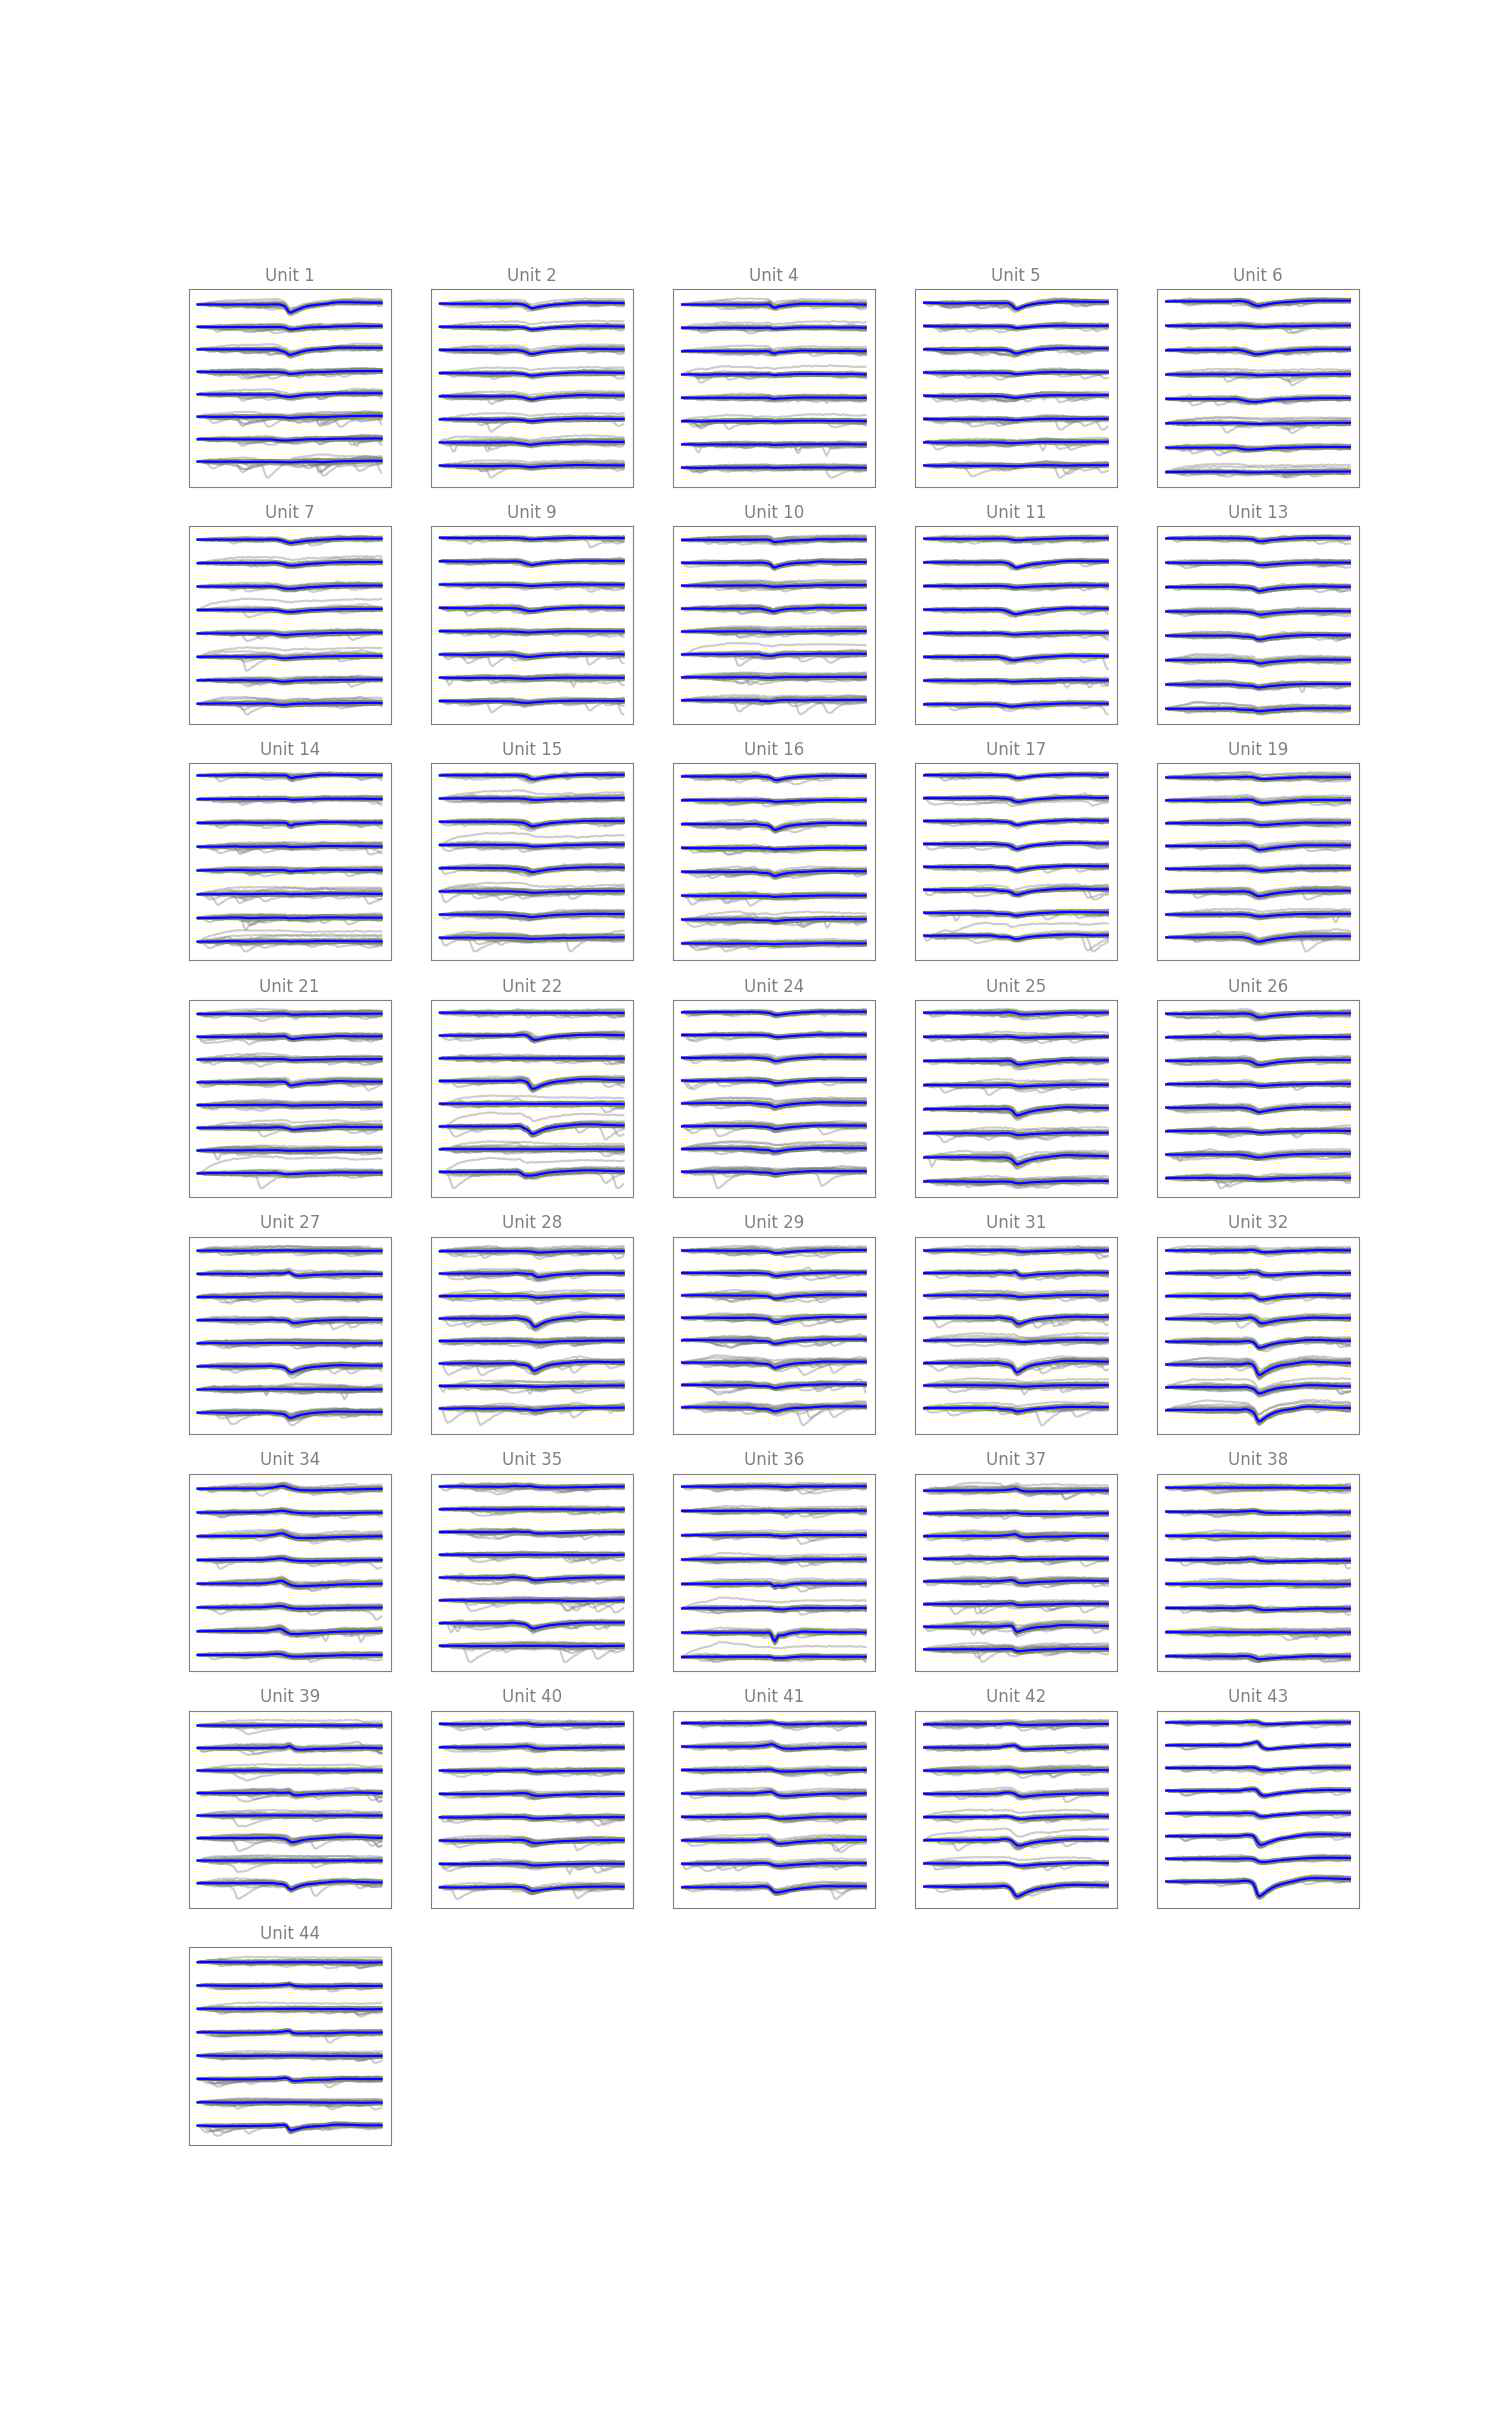

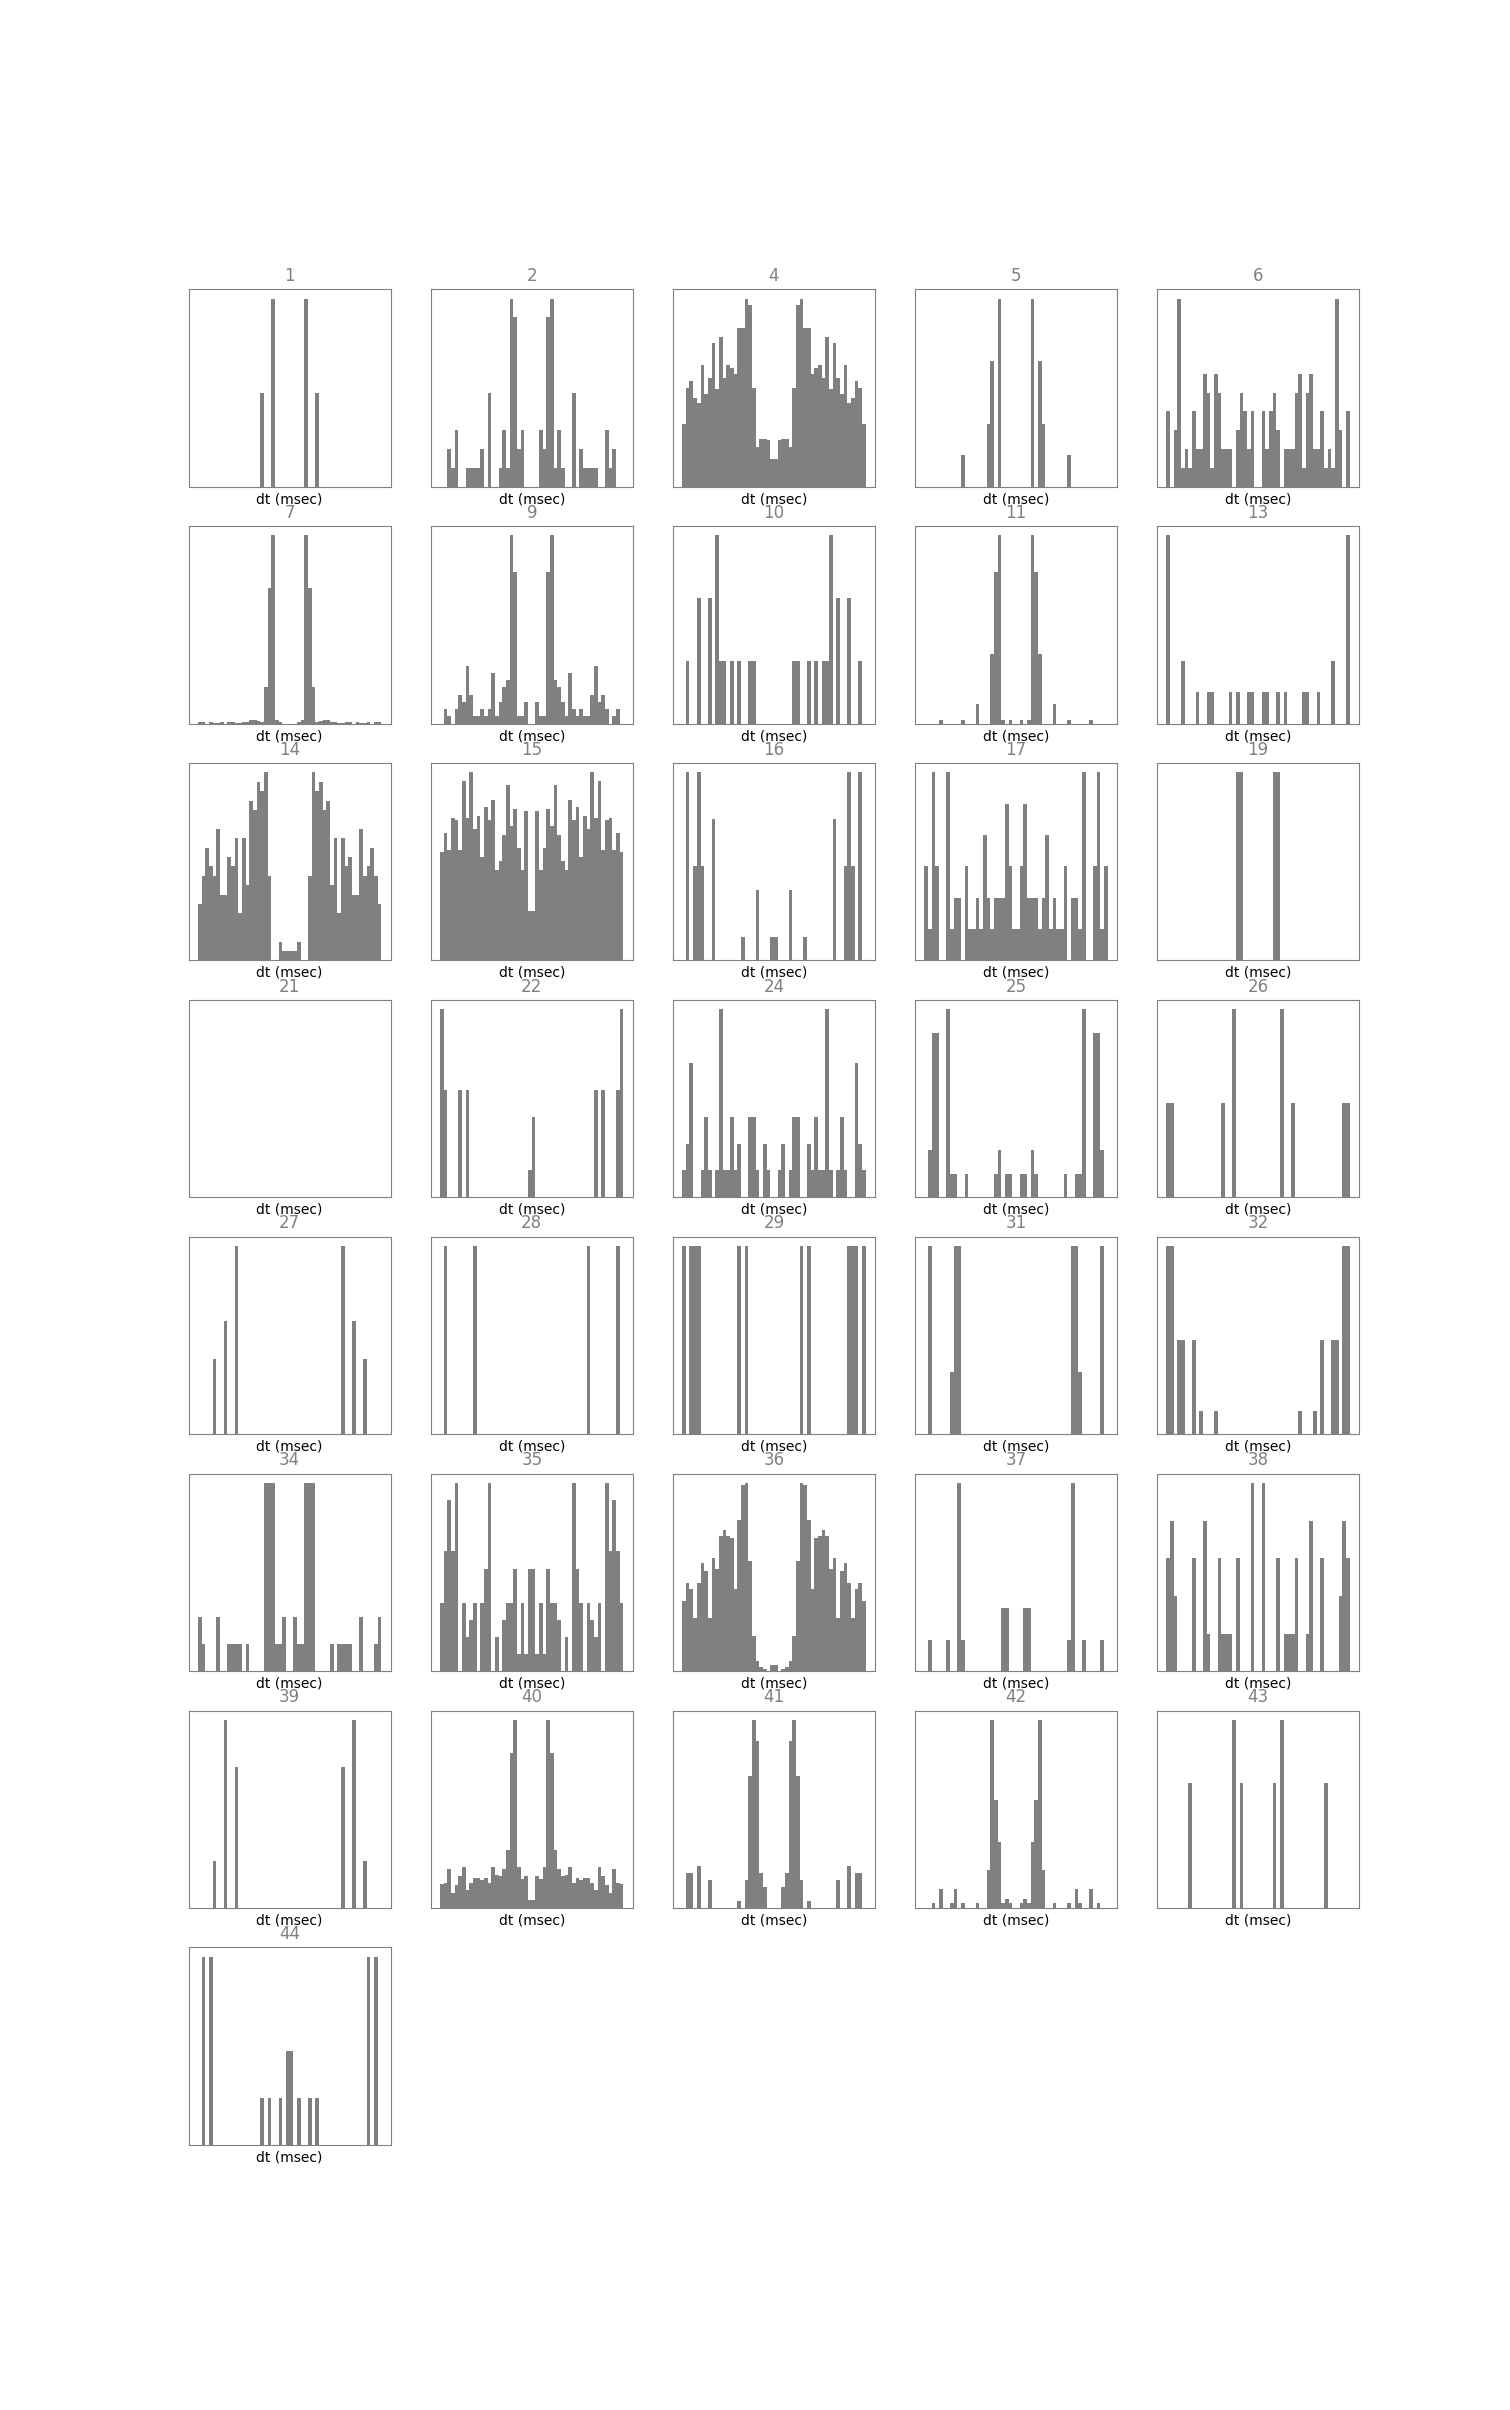

# matches Accuracy Best unit Matched unit Unit ID  f.n.  f.p.
0         20     0.00        16           -1       1  0.99  0.99
1         20     0.00        36           -1       3  1.00  0.99
2       1673     0.84        31           31       4  0.00  0.16
3       2151     0.92        16           16       6  0.03  0.05
4         35     0.00        15           -1      16  0.99  0.99
5         13     0.00        41           -1      21  0.99  0.99
6         23     0.01         9           -1      26  0.99  0.98
7         39     0.00        15           -1      28  0.99  0.98
8       1240     0.53        27           27      50  0.00  0.47
9         12     0.00         7           -1      76  1.00  0.99
10        12     0.00        41           -1      83  1.00  0.99
11        19     0.00        35           -1      84  0.99  0.99
12         6     0.00         1           -1      85  0.99  0.99
13        29     0.01         7           -1     101  0.99  0.98
14       746     0.49         1           -1     104  0.00  0.51
15        23     0.01        24           -1     105  0.98  0.98
16        16     0.00        43           -1     114  0.99  0.99
17        14     0.00         7           -1     120  1.00  0.99
18        12     0.00        43           -1     125  1.00  0.99
19        13     0.00        17           -1     135  0.99  0.99
20        37     0.01         9           -1     143  0.98  0.98
21         8     0.00        34           -1     148  1.00  0.99
22         8     0.00        10           -1     163  1.00  0.99
23        60     0.01        15           -1     170  0.99  0.99
24        51     0.00        15           -1     171  0.99  0.99
25        72     0.01         2           -1     176  0.96  0.99
26      2825     0.50        11           11     186  0.01  0.49
27        43     0.00        22           -1     188  0.99  0.99
28        43     0.00         4           -1     195  0.99  0.99
29        44     0.00        15           -1     204  0.99  0.99
..       ...      ...       ...          ...     ...   ...   ...
55        28     0.00        32           -1     438  0.99  0.99
56      2220     0.63        17           17     443  0.07  0.34
57        19     0.00        35           -1     455  0.99  0.99
58      1170     0.35        13           -1     456  0.06  0.64
59        20     0.00        43           -1     457  0.99  0.99
60        34     0.01        25           -1     473  0.99  0.99
61        29     0.00        40           -1     487  0.99  0.99
62      2758     0.40        15           -1     490  0.58  0.12
63        63     0.01        40           -1     504  0.98  0.98
64        38     0.01        24           -1     531  0.97  0.99
65      3205     0.84         6            6     550  0.06  0.11
66        35     0.00        15           -1     552  0.99  0.99
67        23     0.00        22           -1     563  0.99  0.99
68        22     0.00        41           -1     567  0.99  0.99
69      2450     0.33        15           -1     570  0.62  0.28
70        28     0.00        25           -1     572  0.99  0.99
71        24     0.00        32           -1     585  0.99  0.99
72         2     0.00        28           -1     592  0.99  0.99
73         9     0.00         2           -1     595  0.99  0.99
74        84     0.01         4           -1     615  0.98  0.99
75        69     0.01         4           -1     635  0.99  0.99
76         8     0.00        44           -1     640  0.99  0.99
77       910     0.16         4           -1     641  0.83  0.12
78        81     0.00        15           -1     668  0.99  0.99
79        70     0.01         4           -1     673  0.99  0.99
80        73     0.00        15           -1     676  0.99  0.99
81        69     0.01        36           -1     688  0.99  0.99
82        35     0.00        15           -1     697  0.99  0.99
83        41     0.00        40           -1     701  0.99  0.99
84      4316     0.57         4       

In [21]:
R=X.sortingResult()
display(R.plot('unit_waveforms'))
display(R.plot('autocorrelograms'))
display(R.comparisonWithTruth())

## Aggregate sorting results

In [4]:
SF=sf.SFData()
SF.loadRecordings(key=dict(name='spikeforest_bionet_recordings'))
SF.loadProcessingBatch(key=dict(batch_name='summarize_recordings_bionet',name='job_results'))
SF.loadProcessingBatch(key=dict(batch_name='ms4_bionet',name='job_results'))
#SF.loadProcessingBatch(key=dict(batch_name='sc_bionet',name='job_results')) ## Spyking circus not working yet -- need to put into singularity container
SF.loadProcessingBatch(key=dict(batch_name='irc_bionet',name='job_results'))

Loaded 0 sorting results and 36 recording summary results
Loaded 36 sorting results and 0 recording summary results
Loaded 36 sorting results and 0 recording summary results


In [0]:
import pandas as pd
import random
import altair as alt
alt.renderers.enable('colab')

# Accumulate the sorting results
def accumulate_comparison_with_ground_truth(*,SF,studies,sorter_name,fieldnames):
  ret=[]
  for study in studies:
    recordings=[study.recording(name) for name in study.recordingNames()]
    for R in recordings:
      result=R.sortingResult(sorter_name)
      A=result.comparisonWithTruth(format='json')
      B=R.trueUnitsInfo(format='json')
      snr_by_true_unit=dict()
      for b in B:
        snr_by_true_unit[b['unit_id']]=b['snr']
      for i in A:
        a=A[i]
        rec=dict()
        rec['recording_name']=R.name()
        rec['unit_id']=a['Unit ID']
        rec['snr']=snr_by_true_unit[rec['unit_id']]
        for fieldname in fieldnames:
          rec[fieldname]=float(a[fieldname])
        ret.append(rec)
  return ret

def show_accuracy_plot(*,SF,study_name,sorter_name,title):
  
  study=SF.study(study_name)
  X=accumulate_comparison_with_ground_truth(
      SF=SF,
      studies=[study],
      sorter_name=sorter_name,
      fieldnames=['Accuracy']
  )
  
  # Display the accumulated sorting results
  cc=alt.Chart(pd.DataFrame(X),title=title).mark_point().encode(
      x='snr',
      y='Accuracy',
      color='recording_name',
      tooltip='recording_name'
  ).interactive()
  display(cc)

In [0]:
import vdomr as vd

class SelectBox(vd.Component):
    def __init__(self,options=[]):
        vd.Component.__init__(self)
        self._on_change_handlers=[]
        self._value=None
        self.setOptions(options)
        
    def setOptions(self,options):
        self._options=options
        if self._value not in options:
          self._value=options[0] if options else None
        self.refresh()
        
    def value(self):
        return self._value
    
    def setValue(self,value):
        self._value=value
        self.refresh()
        
    def onChange(self,handler):
        self._on_change_handlers.append(handler)
        
    def _on_change(self,value):
        self._value=value
        for handler in self._on_change_handlers:
            handler(value=value)
        
    def render(self):
        opts=[]
        for option in self._options:
            if option==self._value:
              opts.append(vd.option(option,selected='selected'))
            else:
              opts.append(vd.option(option))
        X=vd.select(opts,onchange=self._on_change)
        return X

In [7]:
STUDY=SelectBox(options=SF.studyNames())
SORTER=SelectBox(options=['MountainSort4-thr3','IronClust-drift'])
display(STUDY)
display(SORTER)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
print(SORTER.value())

IronClust-drift


In [13]:
show_accuracy_plot(
    SF=SF,
    study_name=STUDY.value(),
    sorter_name=SORTER.value(),
    title=SORTER.value()+' '+STUDY.value()
)

Chart({
  data:       Accuracy recording_name        snr  unit_id
  0         0.00  drift_8x_A_2A   3.343870        1
  1         0.00  drift_8x_A_2A   3.443811        3
  2         0.84  drift_8x_A_2A  52.485138        4
  3         0.24  drift_8x_A_2A  27.300165        6
  4         0.00  drift_8x_A_2A   2.593275       16
  5         0.01  drift_8x_A_2A   4.721575       21
  6         0.01  drift_8x_A_2A  14.430388       26
  7         0.00  drift_8x_A_2A   2.585488       28
  8         0.57  drift_8x_A_2A  36.712619       50
  9         0.00  drift_8x_A_2A   3.441622       76
  10        0.00  drift_8x_A_2A   2.688525       83
  11        0.00  drift_8x_A_2A   2.651218       84
  12        0.00  drift_8x_A_2A   4.311581       85
  13        0.01  drift_8x_A_2A   8.701670      101
  14        0.87  drift_8x_A_2A  39.065159      104
  15        0.09  drift_8x_A_2A  12.539603      105
  16        0.02  drift_8x_A_2A   5.921046      114
  17        0.01  drift_8x_A_2A   7.030059      120
  18        0.00  drift_8x_A_2A   5.039221      125
  19        0.04  drift_8x_A_2A   9.906497      135
  20        0.01  drift_8x_A_2A  10.537055      143
  21        0.00  drift_8x_A_2A   5.959964      148
  22        0.00  drift_8x_A_2A   7.627100      163
  23        0.01  drift_8x_A_2A   3.508632      170
  24        0.01  drift_8x_A_2A   4.660825      171
  25        0.03  drift_8x_A_2A  13.201525      176
  26        0.04  drift_8x_A_2A  24.188160      186
  27        0.14  drift_8x_A_2A  11.198612      188
  28        0.00  drift_8x_A_2A   3.891501      195
  29        0.01  drift_8x_A_2A   3.700030      204
  ...        ...            ...        ...      ...
  1020      0.10  drift_8x_C_4B  21.739477      456
  1021      0.01  drift_8x_C_4B   4.187031      457
  1022      0.02  drift_8x_C_4B   6.194982      473
  1023      0.06  drift_8x_C_4B  10.411781      486
  1024      0.06  drift_8x_C_4B  10.661051      487
  1025      0.22  drift_8x_C_4B  23.407474      490
  1026      0.00  drift_8x_C_4B   6.054980      512
  1027      0.01  drift_8x_C_4B   7.571607      519
  1028      0.08  drift_8x_C_4B  13.817746      521
  1029      0.03  drift_8x_C_4B  12.378136      531
  1030      0.00  drift_8x_C_4B   2.885893      549
  1031      0.25  drift_8x_C_4B  23.086075      550
  1032      0.01  drift_8x_C_4B   5.378435      552
  1033      0.04  drift_8x_C_4B  10.277856      563
  1034      0.07  drift_8x_C_4B  13.682997      567
  1035      0.22  drift_8x_C_4B  23.287324      570
  1036      0.02  drift_8x_C_4B  12.398745      572
  1037      0.01  drift_8x_C_4B   4.196825      575
  1038      0.00  drift_8x_C_4B   6.829102      585
  1039      0.00  drift_8x_C_4B   5.193873      595
  1040      0.01  drift_8x_C_4B   2.823507      615
  1041      0.01  drift_8x_C_4B   3.365126      629
  1042      0.01  drift_8x_C_4B   3.963504      635
  1043      0.05  drift_8x_C_4B  14.316911      641
  1044      0.01  drift_8x_C_4B   4.140479      676
  1045      0.01  drift_8x_C_4B   5.746295      688
  1046      0.89  drift_8x_C_4B  37.525818      696
  1047      0.01  drift_8x_C_4B   4.552759      697
  1048      0.17  drift_8x_C_4B  14.454435      701
  1049      0.18  drift_8x_C_4B  17.360271      703
  
  [1050 rows x 4 columns],
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'recording_name'
    }),
    tooltip: Tooltip({
      shorthand: 'recording_name'
    }),
    x: X({
      shorthand: 'snr'
    }),
    y: Y({
      shorthand: 'Accuracy'
    })
  }),
  mark: 'point',
  selection: SelectionMapping({
    selector004: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  }),
  title: 'IronClust-drift bionet_drift'
})

In [11]:
from google.colab import output
print(output.__file__)

/home/jamesjun/src/spikeforest/google/colab/output/__init__.py
